In [24]:
import pandas as pd
import gzip
import networkx as nx
import pickle
from matplotlib.cm import ScalarMappable
import seaborn as sns
import matplotlib.pyplot as plt
import re
import tarfile
import numpy as np
import textwrap
import random

In [2]:
import tarfile

archivo_tgz = '../datos_ceibal/datos_ceibal_clientes/RSSI_WLCs_2018-07-27_11_05.tgz'

with tarfile.open(archivo_tgz, 'r:gz') as tar:
    nombres_archivos = tar.getnames()

    for nombre in nombres_archivos:
        miembro = tar.getmember(nombre)
        f = tar.extractfile(miembro)
        if f is None:
            continue

        print(f'\nArchivo: {nombre}')
        for i, linea in enumerate(f):
            if i >= 3:
                break
            print(linea.decode('utf-8').strip())


Archivo: RSSI_WLCs/datos_ASOCIACION_WLC1.txt
SNMPv2-SMI::enterprises.14179.2.1.4.1.4.0.0.6.109.6.33 = Hex-STRING: 1C 6A 7A B5 85 E0
SNMPv2-SMI::enterprises.14179.2.1.4.1.4.0.0.6.109.44.237 = Hex-STRING: 18 8B 9D 83 2D D0
SNMPv2-SMI::enterprises.14179.2.1.4.1.4.0.0.6.174.241.178 = Hex-STRING: 18 8B 9D 6E A1 C0

Archivo: RSSI_WLCs/datos_ASOCIACION_WLC3.txt
SNMPv2-SMI::enterprises.14179.2.1.4.1.4.0.0.6.108.193.34 = Hex-STRING: 00 F2 8B E9 5F E0
SNMPv2-SMI::enterprises.14179.2.1.4.1.4.0.0.6.108.212.112 = Hex-STRING: 28 6F 7F C9 D5 80
SNMPv2-SMI::enterprises.14179.2.1.4.1.4.0.0.6.108.244.236 = Hex-STRING: 1C 6A 7A EB AF 70

Archivo: RSSI_WLCs/datos_RSSI_WLC1.txt
SNMPv2-SMI::enterprises.14179.2.1.11.1.5.0.0.6.109.6.33.24.139.157.86.96.80.0.0 = INTEGER: -87
SNMPv2-SMI::enterprises.14179.2.1.11.1.5.0.0.6.109.6.33.24.139.157.86.96.80.0.1 = INTEGER: -78
SNMPv2-SMI::enterprises.14179.2.1.11.1.5.0.0.6.109.6.33.24.139.157.131.37.128.0.0 = INTEGER: -92

Archivo: RSSI_WLCs/datos_RSSI_WLC3.txt
SNMPv2

In [3]:
def extraer_mac(numeros):
    """Convierte lista de strings con números decimales a MAC en formato hexadecimal."""
    return ':'.join(f'{int(n):02x}' for n in numeros)

archivo_tgz = '../datos_ceibal/datos_ceibal_clientes/RSSI_WLCs_2018-07-27_11_05.tgz'

# Extraer string de fecha y convertirlo con pd.to_datetime
match_ts = re.search(r'(\d{4}-\d{2}-\d{2}_\d{2}_\d{2})', archivo_tgz)
timestamp_archivo = pd.to_datetime(match_ts.group(1), format='%Y-%m-%d_%H_%M') if match_ts else None


datos = []

with tarfile.open(archivo_tgz, 'r:gz') as tar:
    for nombre in tar.getnames():
        if 'datos_RSSI' not in nombre:
            continue

        # Buscar WLC (ej: WLC1, WLC2, etc.)
        wlc_match = re.search(r'(WLC\d+)', nombre)
        wlc_id = wlc_match.group(1) if wlc_match else None

        miembro = tar.getmember(nombre)
        f = tar.extractfile(miembro)
        if f is None:
            continue

        for linea in f:
            linea = linea.decode('utf-8').strip()
            match = re.search(r'1\.5\.(.*?) = INTEGER: (-?\d+)', linea)
            if not match:
                continue

            partes_oid = match.group(1).split('.')
            if len(partes_oid) < 12:
                continue

            mac_cliente = extraer_mac(partes_oid[0:6])
            mac_ap = extraer_mac(partes_oid[6:12])
            antena = int(partes_oid[12]) if len(partes_oid) > 12 else None
            banda = int(partes_oid[13]) if len(partes_oid) > 13 else None
            rssi = int(match.group(2))

            datos.append({
                'MAC_CLIENT': mac_cliente.lower(),
                'MAC_AP': mac_ap.lower(),
                'BANDA': banda,
                'ANTENA': antena,
                'RSSI': rssi,
                'WLC': wlc_id,
                'timestamp': timestamp_archivo
            })

df_rssi = pd.DataFrame(datos)
df_rssi['timestamp'] = df_rssi['timestamp'].dt.strftime('%Y-%m-%d %H:%M')


In [5]:
df_rssi.head(10)

,MAC_CLIENT,MAC_AP,BANDA,ANTENA,RSSI,WLC,timestamp
0,00:00:06:6d:06:21,18:8b:9d:56:60:50,0,0,-87,WLC1,2018-07-27 11:05
1,00:00:06:6d:06:21,18:8b:9d:56:60:50,1,0,-78,WLC1,2018-07-27 11:05
2,00:00:06:6d:06:21,18:8b:9d:83:25:80,0,0,-92,WLC1,2018-07-27 11:05
3,00:00:06:6d:06:21,18:8b:9d:83:25:80,1,0,-85,WLC1,2018-07-27 11:05
4,00:00:06:6d:06:21,18:8b:9d:8d:bd:60,0,0,-90,WLC1,2018-07-27 11:05
5,00:00:06:6d:06:21,18:8b:9d:8d:bd:60,1,0,-93,WLC1,2018-07-27 11:05
6,00:00:06:6d:06:21,1c:6a:7a:a9:8b:d0,0,0,-97,WLC1,2018-07-27 11:05
7,00:00:06:6d:06:21,1c:6a:7a:a9:8b:d0,1,0,-98,WLC1,2018-07-27 11:05
8,00:00:06:6d:06:21,1c:6a:7a:b5:85:e0,0,0,-55,WLC1,2018-07-27 11:05
9,00:00:06:6d:06:21,1c:6a:7a:b5:85:e0,1,0,-58,WLC1,2018-07-27 11:05


In [4]:
archivo_tgz = '../datos_ceibal/datos_ceibal_clientes/RSSI_WLCs_2018-07-27_11_05.tgz'

# Extraer timestamp del nombre del archivo tgz
match_ts = re.search(r'(\d{4}-\d{2}-\d{2}_\d{2}_\d{2})', archivo_tgz)
timestamp_archivo = pd.to_datetime(match_ts.group(1), format='%Y-%m-%d_%H_%M') if match_ts else None

datos = []

with tarfile.open(archivo_tgz, 'r:gz') as tar:
    for nombre in tar.getnames():
        if 'datos_ASOCIACION' not in nombre:
            continue

        # Buscar WLC (ej: WLC1, WLC2, etc.)
        wlc_match = re.search(r'(WLC\d+)', nombre)
        wlc_id = wlc_match.group(1) if wlc_match else None

        miembro = tar.getmember(nombre)
        f = tar.extractfile(miembro)
        if f is None:
            continue

        for linea in f:
            linea = linea.decode('utf-8').strip()
            match = re.search(r'\.4\.1\.4\.(\d+)\.(\d+)\.(\d+)\.(\d+)\.(\d+)\.(\d+) = Hex-STRING: ([0-9A-Fa-f ]+)', linea)
            if not match:
                continue
                
            # Extraer MAC cliente (6 números decimales)
            mac_cliente = extraer_mac(match.groups()[:6])
            
            # Extraer MAC AP del Hex-STRING
            mac_ap_hex = match.group(7).replace(' ', '')
            mac_ap = ':'.join([mac_ap_hex[i:i+2] for i in range(0, 12, 2)]).lower()
            
            datos.append({
                'MAC_CLIENT': mac_cliente.lower(),
                'MAC_AP': mac_ap.lower(),
                'WLC': wlc_id,
                'timestamp': timestamp_archivo
            })

df_asociacion = pd.DataFrame(datos)
if not df_asociacion.empty:
    df_asociacion['timestamp'] = df_asociacion['timestamp'].dt.strftime('%Y-%m-%d %H:%M')

In [51]:
df_asociacion.head(10)

,MAC_CLIENT,MAC_AP,WLC,timestamp
0,00:00:08:a4:95:aa,18:8b:9d:36:75:00,WLC1,2018-04-30 11:05
1,00:00:08:a5:86:1e,f4:cf:e2:54:1a:f0,WLC1,2018-04-30 11:05
2,00:00:08:a6:e7:08,88:1d:fc:88:30:50,WLC1,2018-04-30 11:05
3,00:00:08:a7:00:a6,00:42:68:d5:f3:20,WLC1,2018-04-30 11:05
4,00:02:26:30:47:ec,1c:6a:7a:7b:d1:20,WLC1,2018-04-30 11:05
5,00:02:87:51:1b:d2,18:8b:9d:62:4b:90,WLC1,2018-04-30 11:05
6,00:02:9a:38:f1:da,18:8b:9d:62:43:40,WLC1,2018-04-30 11:05
7,00:03:ab:63:7f:ee,2c:d0:2d:45:db:e0,WLC1,2018-04-30 11:05
8,00:03:ab:e4:06:e1,88:1d:fc:88:30:50,WLC1,2018-04-30 11:05
9,00:08:22:04:2f:4b,88:1d:fc:77:c9:50,WLC1,2018-04-30 11:05


## Hay MAC virtuales ?

In [54]:
todos_terminan_en_0 = df_asociacion['MAC_AP'].str.endswith('0').all()

if todos_terminan_en_0:
    print("Todas las MAC_AP terminan en 0.")
else:
    print("No todas las MAC_AP terminan en 0.")


Todas las MAC_AP terminan en 0.


¿Por qué todas terminan en 0?
Si en tus datos todas las MAC_AP terminan en 0, hay varias interpretaciones posibles:

Estás viendo la MAC base de la radio, es decir, la BSSID del primer SSID anunciado.

No se están publicando variaciones para otros SSID, o estás limitando la consulta al primer SSID por radio.

La terminación en 0 en el último nibble hexadecimal suele indicar que se trata justamente de esa MAC base sin offset.


Si tu WLC tiene varios SSID, deberías ver direcciones como ...60, ...61, ...62, etc., pero si sólo ves ...60 (o en tu caso ...*0), significa que solo estás viendo el primer BSSID por radio.

Esto sí sugiere que son MAC base del radio, no versiones offset para SSID adicionales.


In [ ]:
# Merge para agregar el AP real de conexión al DataFrame de RSSI
df_merged = df_rssi.merge(
    df_asociacion,
    on=["MAC_CLIENT", "WLC", "timestamp"],
    how="left",
    suffixes=("", "_real")
)

# Marcar si el AP con el que se conectó es igual al del RSSI actual
df_merged["is_real_ap"] = df_merged["MAC_AP"] == df_merged["MAC_AP_real"]

# Obtener el mejor RSSI por MAC_CLIENT y BANDA (sin warning)
best_rssi_per_band = (
    df_merged.groupby(['MAC_CLIENT', 'BANDA'], group_keys=False)
    .apply(lambda group: group.loc[group['RSSI'].idxmax()])
    .reset_index(drop=True)
)

# Marcar si el AP real es el mejor (mejor RSSI en esa banda)
df_merged = df_merged.merge(
    best_rssi_per_band[['MAC_CLIENT', 'BANDA', 'MAC_AP']],
    on=['MAC_CLIENT', 'BANDA'],
    how='left',
    suffixes=('', '_best')
)

df_merged['is_best_ap'] = df_merged['MAC_AP'] == df_merged['MAC_AP_best']


In [20]:
accuracy = df_merged[df_merged['is_real_ap']].groupby('BANDA')['is_best_ap'].mean() * 100

In [21]:
accuracy.head()

BANDA
0    72.952099
1    73.197071
Name: is_best_ap, dtype: float64

## Bulk archivos

In [35]:
import re
import tarfile
import pandas as pd
import glob

def extraer_mac(numeros):
    """Convierte lista de strings con números decimales a MAC en formato hexadecimal."""
    return ':'.join(f'{int(n):02x}' for n in numeros)

def procesar_archivo_tgz(archivo_tgz):
    """Procesa un archivo .tgz y extrae datos de RSSI y ASOCIACION"""
    # Extraer timestamp del nombre del archivo tgz
    match_ts = re.search(r'(\d{4}-\d{2}-\d{2}_\d{2}_\d{2})', archivo_tgz)
    timestamp_archivo = pd.to_datetime(match_ts.group(1), format='%Y-%m-%d_%H_%M') if match_ts else None
    
    datos_rssi = []
    datos_asociacion = []
    
    with tarfile.open(archivo_tgz, 'r:gz') as tar:
        for nombre in tar.getnames():
            # Procesar archivos de RSSI
            if 'datos_RSSI' in nombre:
                wlc_match = re.search(r'(WLC\d+)', nombre)
                wlc_id = wlc_match.group(1) if wlc_match else None

                miembro = tar.getmember(nombre)
                f = tar.extractfile(miembro)
                if f is None:
                    continue

                for linea in f:
                    linea = linea.decode('utf-8').strip()
                    match = re.search(r'1\.5\.(.*?) = INTEGER: (-?\d+)', linea)
                    if not match:
                        continue

                    partes_oid = match.group(1).split('.')
                    if len(partes_oid) < 12:
                        continue

                    mac_cliente = extraer_mac(partes_oid[0:6])
                    mac_ap = extraer_mac(partes_oid[6:12])
                    banda = int(partes_oid[12]) if len(partes_oid) > 12 else None
                    antena = int(partes_oid[13]) if len(partes_oid) > 13 else None
                    rssi = int(match.group(2))

                    datos_rssi.append({
                        'MAC_CLIENT': mac_cliente.lower(),
                        'MAC_AP': mac_ap.lower(),
                        'BANDA': banda,
                        'ANTENA': antena,
                        'RSSI': rssi,
                        'WLC': wlc_id,
                        'timestamp': timestamp_archivo
                    })
            
            # Procesar archivos de ASOCIACION
            elif 'datos_ASOCIACION' in nombre:
                wlc_match = re.search(r'(WLC\d+)', nombre)
                wlc_id = wlc_match.group(1) if wlc_match else None

                miembro = tar.getmember(nombre)
                f = tar.extractfile(miembro)
                if f is None:
                    continue

                for linea in f:
                    linea = linea.decode('utf-8').strip()
                    match = re.search(r'\.4\.1\.4\.(\d+)\.(\d+)\.(\d+)\.(\d+)\.(\d+)\.(\d+) = Hex-STRING: ([0-9A-Fa-f ]+)', linea)
                    if not match:
                        continue
                        
                    mac_cliente = extraer_mac(match.groups()[:6])
                    mac_ap_hex = match.group(7).replace(' ', '')
                    mac_ap = ':'.join([mac_ap_hex[i:i+2] for i in range(0, 12, 2)]).lower()
                    
                    datos_asociacion.append({
                        'MAC_CLIENT': mac_cliente.lower(),
                        'MAC_AP': mac_ap.lower(),
                        'WLC': wlc_id,
                        'timestamp': timestamp_archivo
                    })
    
    # Crear DataFrames
    df_rssi = pd.DataFrame(datos_rssi)
    if not df_rssi.empty:
        df_rssi['timestamp'] = df_rssi['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
    
    df_asociacion = pd.DataFrame(datos_asociacion)
    if not df_asociacion.empty:
        df_asociacion['timestamp'] = df_asociacion['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
    
    return df_rssi, df_asociacion

In [36]:
def analizar_mejor_ap(df_rssi, df_asociacion):
    """
    Analiza si los clientes están conectados al mejor AP disponible (según RSSI).
    Devuelve el DataFrame fusionado y el porcentaje de clientes conectados al mejor AP.
    """
    try:
        # Merge para agregar el AP real de conexión al DataFrame de RSSI
        df_merged = df_rssi.merge(
            df_asociacion,
            on=["MAC_CLIENT", "WLC", "timestamp"],
            how="left",
            suffixes=("", "_real")
        )

        # Marcar si el AP con el que se conectó es igual al del RSSI actual
        df_merged["es_ap_real"] = df_merged["MAC_AP"] == df_merged["MAC_AP_real"]

        # Obtener el mejor RSSI por cliente y banda
        best_rssi_per_band = (
            df_merged.groupby(['MAC_CLIENT', 'BANDA'], group_keys=False)
            .apply(lambda group: group.loc[group['RSSI'].idxmax()])
            .reset_index(drop=True)
        )

        # Marcar si el AP real es el mejor
        df_merged = df_merged.merge(
            best_rssi_per_band[['MAC_CLIENT', 'BANDA', 'MAC_AP']],
            on=['MAC_CLIENT', 'BANDA'],
            how='left',
            suffixes=('', '_mejor')
        )

        df_merged['es_mejor_ap'] = df_merged['MAC_AP_real'] == df_merged['MAC_AP_mejor']

        # Calcular porcentaje de clientes conectados al mejor AP
        porcentaje_mejor_ap = df_merged['es_mejor_ap'].mean() * 100

        return df_merged, porcentaje_mejor_ap

    except Exception as e:
        print(f"Error al analizar mejor AP: {e}")
        return None, None


In [ ]:
archivos_tgz = random.sample(glob.glob('../datos_ceibal/datos_ceibal_clientes/RSSI_WLCs_*.tgz'), 20)
resultados_por_archivo = []

for archivo in archivos_tgz:
    # print(f"Procesando archivo: {archivo}")
    df_rssi, df_asociacion = procesar_archivo_tgz(archivo)
    
    if not df_rssi.empty and not df_asociacion.empty:
        df_resultado, porcentaje = analizar_mejor_ap(df_rssi, df_asociacion)
        
        if porcentaje is not None:
            fecha = re.search(r'(\d{4}-\d{2}-\d{2})', archivo).group(1)
            resultados_por_archivo.append({
                'archivo': archivo,
                'fecha': fecha,
                'porcentaje_mejor_ap': porcentaje,
                'clientes_totales': len(df_resultado),
                'clientes_correctos': df_resultado['es_mejor_ap'].sum()
            })
            # print(f"  ✔ Porcentaje conectados al mejor AP: {porcentaje:.2f}%")
        # else:
            # print("  ⚠ No se pudo realizar el análisis (datos insuficientes)")
    # else:
        # print("  ⚠ Archivo sin datos suficientes para análisis")


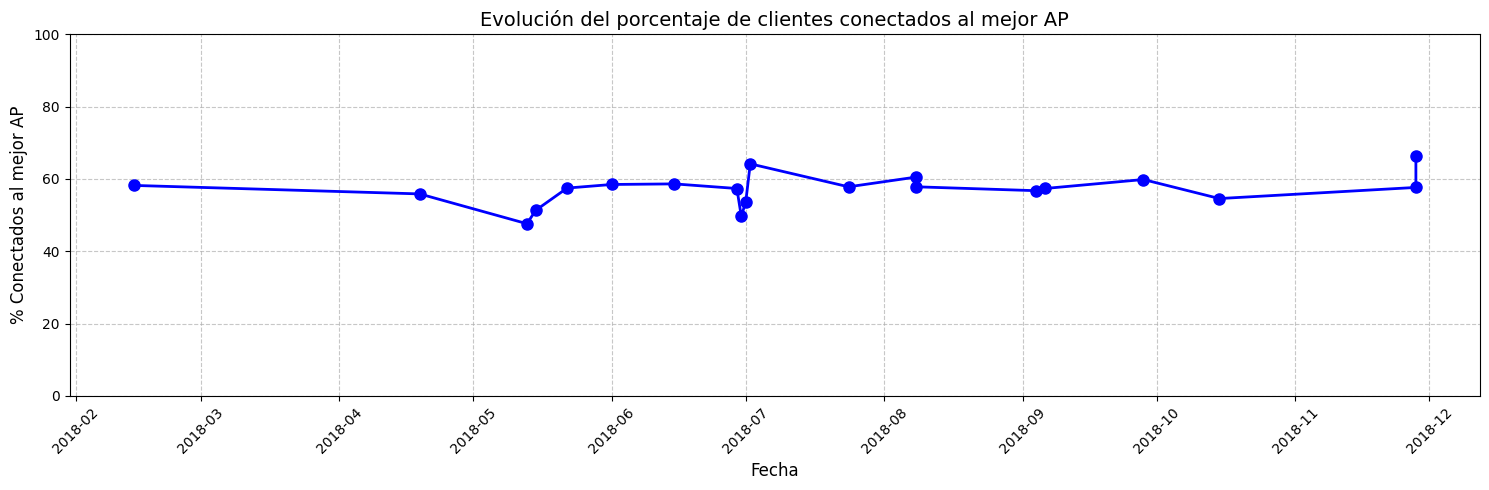

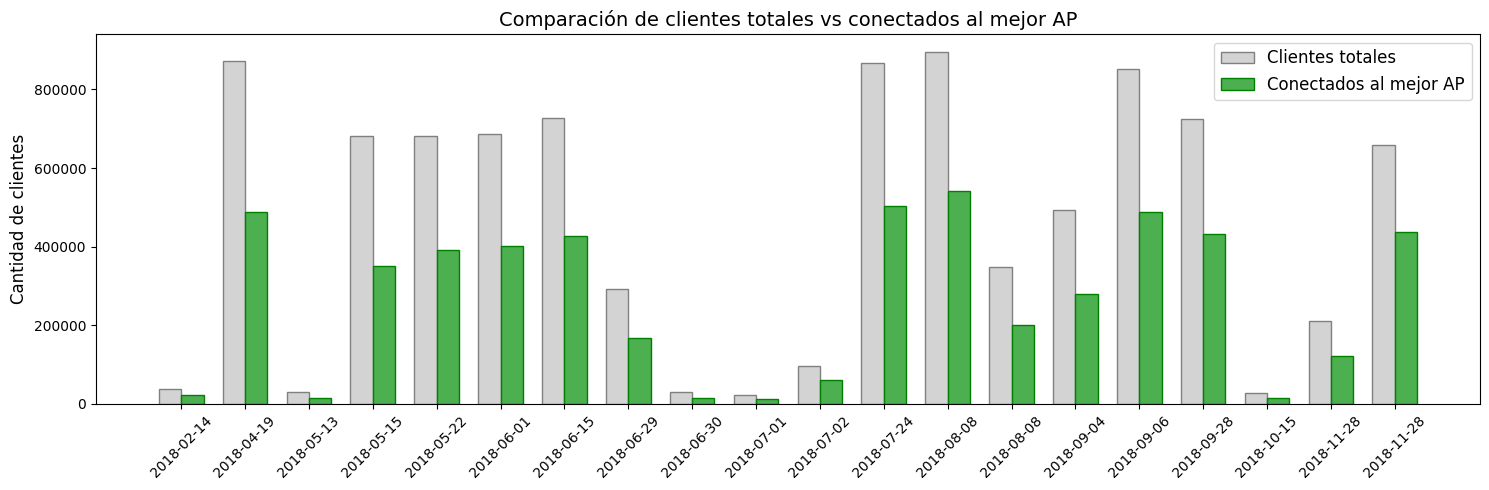

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convertir los resultados a DataFrame
df_resultados = pd.DataFrame(resultados_por_archivo)

# Asegurarse de tener el DataFrame ordenado por fecha
df_resultados['fecha'] = pd.to_datetime(df_resultados['fecha'])
df_resultados = df_resultados.sort_values(by='fecha')

# Gráfico 1: Evolución del porcentaje de clientes conectados al mejor AP (sin valores en puntos)
plt.figure(figsize=(15, 5))
plt.plot(df_resultados['fecha'], df_resultados['porcentaje_mejor_ap'], 
         marker='o', linestyle='-', color='blue', linewidth=2, markersize=8)
plt.title('Evolución del porcentaje de clientes conectados al mejor AP', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('% Conectados al mejor AP', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.ylim(0, 100)  # Asegurar que el eje y vaya de 0 a 100%
plt.tight_layout()
plt.show()

# Gráfico 2: Comparación de clientes totales vs conectados al mejor AP (sin valores en barras)
x = np.arange(len(df_resultados))
width = 0.35

plt.figure(figsize=(15, 5))
plt.bar(x - width/2, df_resultados['clientes_totales'], width, 
        label='Clientes totales', color='lightgray', edgecolor='gray')
plt.bar(x + width/2, df_resultados['clientes_correctos'], width, 
        label='Conectados al mejor AP', color='#4CAF50', edgecolor='green')

plt.xticks(x, df_resultados['fecha'].dt.strftime('%Y-%m-%d'), rotation=45)
plt.ylabel('Cantidad de clientes', fontsize=12)
plt.title('Comparación de clientes totales vs conectados al mejor AP', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()